### Descarga de Datos

In [8]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros del portafolio ---
tickers = ['CRM','UNH','CVX','MSFT']
weights = np.array([0.000621, 0.418453, 0.479852, 0.153705])
start = '2025-09-11'
rf_annual = 0.045

def get_close_df(ticker, colname):
    data = yf.download(ticker, start=start, auto_adjust=False)['Close']
    df = pd.DataFrame(data)
    df.columns = [colname]
    return df

prices_raw = yf.download(tickers, start=start, auto_adjust=False)['Close']
prices = pd.DataFrame(prices_raw)

# Benchmark e índices/ETFs
benchmark   = get_close_df('^GSPC', 'Benchmark')
etf_SP      = get_close_df('SPY',   'SPY')   # S&P 500
etf_nasdaq  = get_close_df('QQQ',   'QQQ')   # Nasdaq 100
etf_oro     = get_close_df('GLD',   'GLD')   # Oro
etf_dow     = get_close_df('DIA',   'DIA')   # Dow Jones
etf_russell = get_close_df('IWM',   'IWM')   # Russell 2000

[*********************100%***********************]  4 of 4 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [9]:
asset_rets = prices.pct_change().dropna()
port_rets = (asset_rets * weights).sum(axis=1)
port_price = 10000 * (1 + port_rets).cumprod()
port_price.iloc[0] = 10000
port_price = pd.DataFrame(port_price)
port_price.columns = ['Portafolio']

history = pd.concat(
    [benchmark, port_price, etf_SP, etf_nasdaq, etf_oro, etf_dow, etf_russell],
    axis=1
)

### Metricas

In [10]:
def performance_metrics(history, rf):
    rets = history.pct_change().dropna()
    metrics = pd.DataFrame(columns=rets.columns)
    metrics.loc['Rend Prom'] = rets.mean() * 252
    metrics.loc['Volatilidad'] = rets.std() * np.sqrt(252)
    metrics.loc['Sharpe'] = (metrics.loc['Rend Prom'] - rf) / metrics.loc['Volatilidad']

    downside = rets.copy()
    downside[downside > 0] = 0
    metrics.loc['Downside Risk'] = downside.std() * np.sqrt(252)

    upside = rets.copy()
    upside[upside < 0] = 0
    metrics.loc['Upside Risk'] = upside.std() * np.sqrt(252)

    metrics.loc['Omega'] = metrics.loc['Upside Risk'] / metrics.loc['Downside Risk']

    cov = rets.cov()
    metrics.loc['Beta'] = cov.loc['Benchmark'] / cov.loc['Benchmark', 'Benchmark']

    Rm = metrics.loc['Rend Prom', 'Benchmark']
    E_r_CAPM = rf + metrics.loc['Beta'] * (Rm - rf)
    metrics.loc['Alfa de Jensen'] = metrics.loc['Rend Prom'] - E_r_CAPM

    metrics.loc['Ratio de Treynor'] = (metrics.loc['Rend Prom'] - rf) / metrics.loc['Beta']
    metrics.loc['Ratio de Sortino'] = (metrics.loc['Rend Prom'] - rf) / metrics.loc['Downside Risk']
    diff_rets = rets.sub(rets['Benchmark'], axis=0)
    tracking_error = diff_rets.std() * np.sqrt(252)
    excess_return = metrics.loc['Rend Prom'] - metrics.loc['Rend Prom', 'Benchmark']
    metrics.loc['Information Ratio'] = excess_return / tracking_error

    return metrics

metrics_total = performance_metrics(history, rf_annual)
print(metrics_total)

                      Benchmark  Portafolio       SPY       QQQ       GLD  \
Rend Prom          1.705005e-01   -0.215899  0.166782  0.235154  0.664011   
Volatilidad        1.303383e-01    0.135605  0.130072  0.182409  0.249881   
Sharpe             9.628833e-01   -1.923957  0.936270  1.042457  2.477228   
Downside Risk      8.595473e-02    0.096745  0.086142  0.117945  0.166136   
Upside Risk        6.913946e-02    0.061144  0.068271  0.097564  0.138157   
Omega              8.043706e-01    0.632013  0.792538  0.827204  0.831589   
Beta               1.000000e+00    0.650917  0.996050  1.355121  0.367533   
Alfa de Jensen     2.775558e-17   -0.342589 -0.003223  0.020085  0.572886   
Ratio de Treynor   1.255005e-01   -0.400818  0.122265  0.140322  1.684234   
Ratio de Sortino   1.460077e+00   -2.696764  1.413744  1.612228  3.725923   
Information Ratio           NaN   -3.355401 -0.461841  0.995327  1.907437   

                        DIA       IWM  
Rend Prom          0.159244  0.1973

### Evolucion Portafolio

In [11]:
cuts = [
    ('E1-E2', '2025-09-11', '2025-09-25'),
    ('E2-E3', '2025-09-25', '2025-10-17'),
    ('E3-E4', '2025-10-17', '2025-11-06'),
    ('E4-E5', '2025-11-06', history.index.max().strftime('%Y-%m-%d'))
]

def performance_metrics_windows(history, rf, cuts):
    resultados = {}

    for nombre, inicio, fin in cuts:
        sub = history.loc[inicio:fin]
        if sub.shape[0] > 10:
            resultados[nombre] = performance_metrics(sub, rf)

    panel = pd.concat(resultados, axis=1)
    return panel

metrics_por_ventana = performance_metrics_windows(history, rf_annual, cuts)

metrics_pf_bm = metrics_por_ventana.loc[:, (slice(None), ['Portafolio', 'Benchmark'])]
print(metrics_pf_bm)


                       E1-E2      E2-E3      E3-E4      E4-E5     E1-E2  \
                  Portafolio Portafolio Portafolio Portafolio Benchmark   
Rend Prom           0.260492  -0.132897  -0.551836  -0.281073  0.088907   
Volatilidad         0.083221   0.135110   0.152336   0.154487  0.069502   
Sharpe              2.589383  -1.316679  -3.917904  -2.110677  0.631742   
Downside Risk       0.041605   0.098524   0.113583   0.104256  0.035038   
Upside Risk         0.052691   0.065794   0.057271   0.069709  0.039355   
Omega               1.266466   0.667800   0.504227   0.668633  1.123230   
Beta               -0.084636   0.809910   0.778076   0.528920  1.000000   
Alfa de Jensen      0.219208  -0.263199  -0.685126  -0.438755  0.000000   
Ratio de Treynor   -2.546118  -0.219650  -0.767066  -0.616489  0.043907   
Ratio de Sortino    5.179523  -1.805622  -5.254643  -3.127611  1.253154   
Information Ratio   1.530175  -3.727150  -5.825523  -3.608388       NaN   

                      E2

In [24]:
def resumen_valor_portafolio(history, cuts):
    filas = []

    for nombre, inicio, fin in cuts:
        sub = history.loc[inicio:fin]

        if sub.shape[0] < 2:
            continue

        fecha_ini_real = sub.index[0]
        fecha_fin_real = sub.index[-1]

        valor_ini = sub['Portafolio'].iloc[0]
        valor_fin = sub['Portafolio'].iloc[-1]

        rendimiento = valor_fin / valor_ini - 1

        filas.append({
            'Ventana'             : nombre,
            'Fecha inicio (real)' : fecha_ini_real,
            'Valor inicio ($)'    : valor_ini,
            'Fecha fin (real)'    : fecha_fin_real,
            'Valor fin ($)'       : valor_fin,
            'Rendimiento ventana' : rendimiento
        })

    return pd.DataFrame(filas)

resumen_entregas = resumen_valor_portafolio(history, cuts)
print(resumen_entregas)

  Ventana Fecha inicio (real)  Valor inicio ($) Fecha fin (real)  \
0   E1-E2          2025-09-11               NaN       2025-09-25   
1   E2-E3          2025-09-25      10092.310913       2025-10-17   
2   E3-E4          2025-10-17      10002.017766       2025-11-06   
3   E4-E5          2025-11-06       9693.853128       2025-11-26   

   Valor fin ($)  Rendimiento ventana  
0   10092.310913                  NaN  
1   10002.017766            -0.008947  
2    9693.853128            -0.030810  
3    9537.672698            -0.016111  


In [25]:
for _, fila in resumen_entregas.iterrows():
    ventana = fila['Ventana']
    fi = fila['Fecha inicio (real)'].date()
    ff = fila['Fecha fin (real)'].date()
    vi = fila['Valor inicio ($)']
    vf = fila['Valor fin ($)']
    r  = fila['Rendimiento ventana']

    print(f"{ventana}:")
    print(f"  Entre el {fi} y el {ff}, el portafolio pasó de ${vi:,.2f} a ${vf:,.2f},")
    print(f"  lo que equivale a un rendimiento de {r*100:.2f}% en ese periodo.\n")

E1-E2:
  Entre el 2025-09-11 y el 2025-09-25, el portafolio pasó de $nan a $10,092.31,
  lo que equivale a un rendimiento de nan% en ese periodo.

E2-E3:
  Entre el 2025-09-25 y el 2025-10-17, el portafolio pasó de $10,092.31 a $10,002.02,
  lo que equivale a un rendimiento de -0.89% en ese periodo.

E3-E4:
  Entre el 2025-10-17 y el 2025-11-06, el portafolio pasó de $10,002.02 a $9,693.85,
  lo que equivale a un rendimiento de -3.08% en ese periodo.

E4-E5:
  Entre el 2025-11-06 y el 2025-11-26, el portafolio pasó de $9,693.85 a $9,537.67,
  lo que equivale a un rendimiento de -1.61% en ese periodo.



       Portafolio  Benchmark
E1-E2    2.589383   0.631742
E2-E3   -1.316679   0.742228
E3-E4   -3.917904   0.926675
E4-E5   -2.110677   1.303843


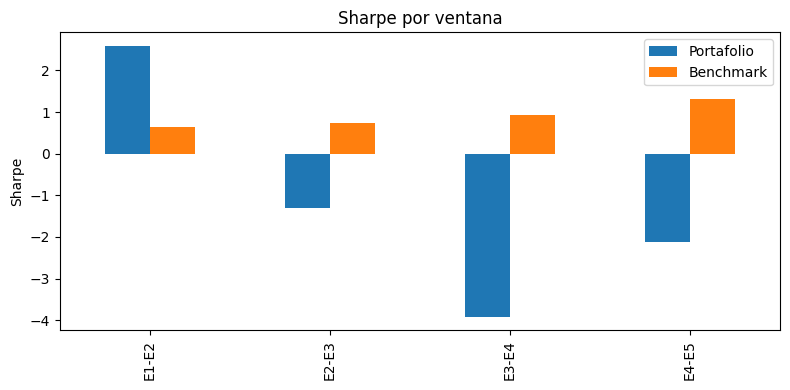

In [14]:
idx = pd.IndexSlice
sharpe_mult = metrics_por_ventana.loc['Sharpe', idx[:, ['Portafolio', 'Benchmark']]]
sharpe_mult = sharpe_mult.unstack(level=1)

print(sharpe_mult)
sharpe_mult.plot(kind='bar', figsize=(8,4), title='Sharpe por ventana')
plt.ylabel('Sharpe')
plt.tight_layout()
plt.show()

In [17]:

pf_window_table = metrics_por_ventana.xs('Portafolio', level=1, axis=1)
print(pf_window_table)

                      E1-E2     E2-E3     E3-E4     E4-E5
Rend Prom          0.260492 -0.132897 -0.551836 -0.281073
Volatilidad        0.083221  0.135110  0.152336  0.154487
Sharpe             2.589383 -1.316679 -3.917904 -2.110677
Downside Risk      0.041605  0.098524  0.113583  0.104256
Upside Risk        0.052691  0.065794  0.057271  0.069709
Omega              1.266466  0.667800  0.504227  0.668633
Beta              -0.084636  0.809910  0.778076  0.528920
Alfa de Jensen     0.219208 -0.263199 -0.685126 -0.438755
Ratio de Treynor  -2.546118 -0.219650 -0.767066 -0.616489
Ratio de Sortino   5.179523 -1.805622 -5.254643 -3.127611
Information Ratio  1.530175 -3.727150 -5.825523 -3.608388


In [18]:
pf_ratios = pf_window_table.loc[['Sharpe', 'Ratio de Sortino', 'Ratio de Treynor', 'Information Ratio']]
print(pf_ratios)

                      E1-E2     E2-E3     E3-E4     E4-E5
Sharpe             2.589383 -1.316679 -3.917904 -2.110677
Ratio de Sortino   5.179523 -1.805622 -5.254643 -3.127611
Ratio de Treynor  -2.546118 -0.219650 -0.767066 -0.616489
Information Ratio  1.530175 -3.727150 -5.825523 -3.608388


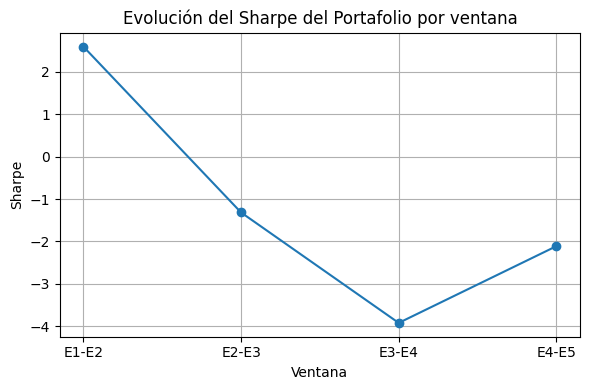

In [21]:
sharpe_pf = metrics_por_ventana.loc['Sharpe'].xs('Portafolio', level=1)
sharpe_pf = sharpe_pf.sort_index()

plt.figure(figsize=(6,4))
plt.plot(sharpe_pf.index, sharpe_pf.values, marker='o')
plt.title('Evolución del Sharpe del Portafolio por ventana')
plt.xlabel('Ventana')
plt.ylabel('Sharpe')
plt.grid(True)
plt.tight_layout()
plt.show()

              Sharpe  Ratio de Sortino  Information Ratio
Benchmark   0.926675          1.526474                NaN
Portafolio -3.917904         -5.254643          -5.825523
SPY         0.989980          1.607123           1.140393
QQQ         1.049764          1.626243           1.163357
GLD        -2.920157         -3.801178          -3.110287
DIA         2.496254          5.249845           2.115509
IWM        -1.307666         -2.412875          -3.260256


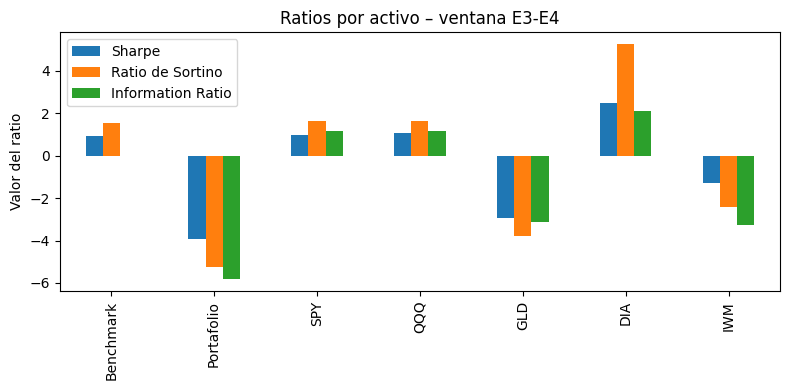

In [22]:
ventana = 'E3-E4'

metrics_E3E4 = metrics_por_ventana.xs(ventana, level=0, axis=1)
ratios_E3E4 = metrics_E3E4.loc[['Sharpe', 'Ratio de Sortino', 'Information Ratio']].T
print(ratios_E3E4)

ratios_E3E4.plot(kind='bar', figsize=(8,4), title=f'Ratios por activo – ventana {ventana}')
plt.ylabel('Valor del ratio')
plt.tight_layout()
plt.show()

### Gráfica de comparación

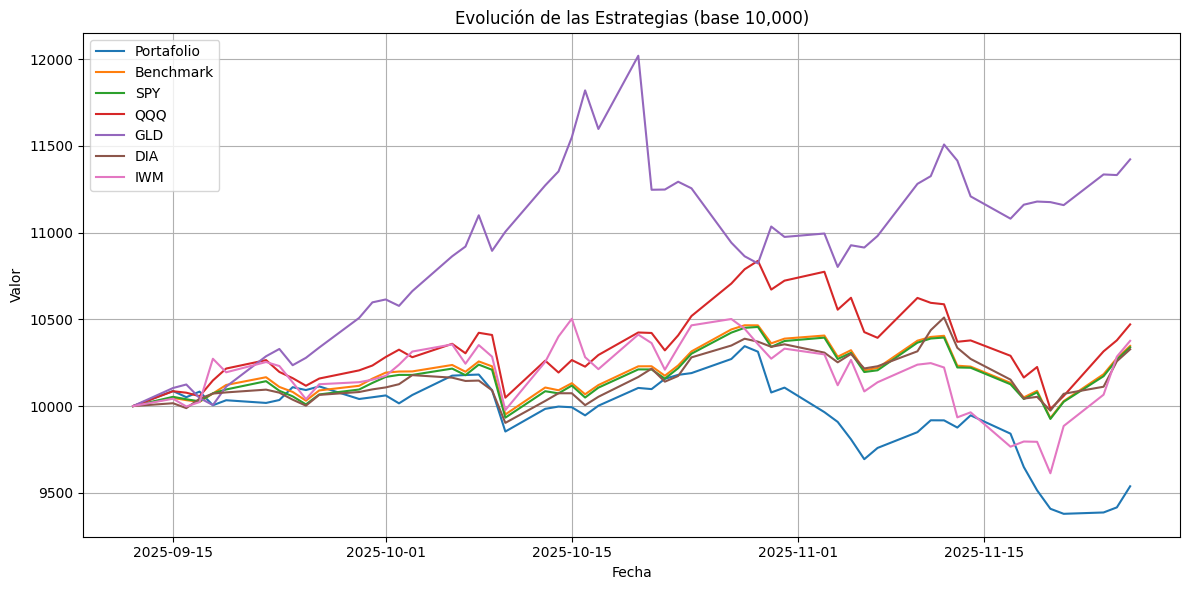

In [13]:
cols = ['Portafolio', 'Benchmark', 'SPY', 'QQQ', 'GLD', 'DIA', 'IWM']
strategies = history[cols].dropna()

base = 10000
norm_strategies = strategies / strategies.iloc[0] * base

plt.figure(figsize=(12, 6))
for col in norm_strategies.columns:
    plt.plot(norm_strategies.index, norm_strategies[col], label=col)

plt.title('Evolución de las Estrategias (base 10,000)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()